In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=6c6469be44156815d7e7efc895087f95ac919c8422638a01fd39c9809442acd6
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('K_means').getOrCreate()
df=spark.read.csv('Country-data.csv',inferSchema=True,header=True)
print((df.count(), len(df.columns)))
df.printSchema()


(167, 10)
root
 |-- country: string (nullable = true)
 |-- child_mort: double (nullable = true)
 |-- exports: double (nullable = true)
 |-- health: double (nullable = true)
 |-- imports: double (nullable = true)
 |-- income: integer (nullable = true)
 |-- inflation: double (nullable = true)
 |-- life_expec: double (nullable = true)
 |-- total_fer: double (nullable = true)
 |-- gdpp: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import rand
df.orderBy(rand()).show(10,False)


+--------------+----------+-------+------+-------+------+---------+----------+---------+-----+
|country       |child_mort|exports|health|imports|income|inflation|life_expec|total_fer|gdpp |
+--------------+----------+-------+------+-------+------+---------+----------+---------+-----+
|Vietnam       |23.3      |72.0   |6.84  |80.2   |4490  |12.1     |73.1      |1.95     |1310 |
|Guinea-Bissau |114.0     |14.9   |8.5   |35.2   |1390  |2.97     |55.6      |5.05     |547  |
|Bolivia       |46.6      |41.2   |4.84  |34.3   |5410  |8.78     |71.6      |3.2      |1980 |
|Spain         |3.8       |25.5   |9.54  |26.8   |32500 |0.16     |81.9      |1.37     |30700|
|Uganda        |81.0      |17.1   |9.01  |28.6   |1540  |10.6     |56.8      |6.15     |595  |
|Morocco       |33.5      |32.2   |5.2   |43.0   |6440  |0.976    |73.5      |2.58     |2830 |
|Angola        |119.0     |62.3   |2.85  |42.9   |5900  |22.4     |60.1      |6.16     |3530 |
|Czech Republic|3.4       |66.0   |7.88  |62.9   |

In [ ]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
df_cols=df.drop("country")
input_cols=df_cols.columns
vec_assembler = VectorAssembler(inputCols = input_cols,
outputCol='features')
final_data = vec_assembler.transform(df)

In [ ]:
errors=[]
for k in range(2,20):
    kmeans = KMeans(featuresCol='features',k=k,distanceMeasure='cosine')
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    training_cost = model.summary.trainingCost
    print(training_cost)
    errors.append(training_cost)

print(errors)

0.8218728365257997
0.42677956087009616
0.33339833342375313
0.27174315821858996
0.23298218190003772
0.20360472800034546
0.1377402191891377
0.12494591209390193
0.11780174915879127
0.11397693193064085
0.0945383294789004
0.08755727150350934
0.08452253603567383
0.09555082684207439
0.09304266438421305
0.08838132685878353
0.07742745165851483
0.07902795789843398
[0.8218728365257997, 0.42677956087009616, 0.33339833342375313, 0.27174315821858996, 0.23298218190003772, 0.20360472800034546, 0.1377402191891377, 0.12494591209390193, 0.11780174915879127, 0.11397693193064085, 0.0945383294789004, 0.08755727150350934, 0.08452253603567383, 0.09555082684207439, 0.09304266438421305, 0.08838132685878353, 0.07742745165851483, 0.07902795789843398]


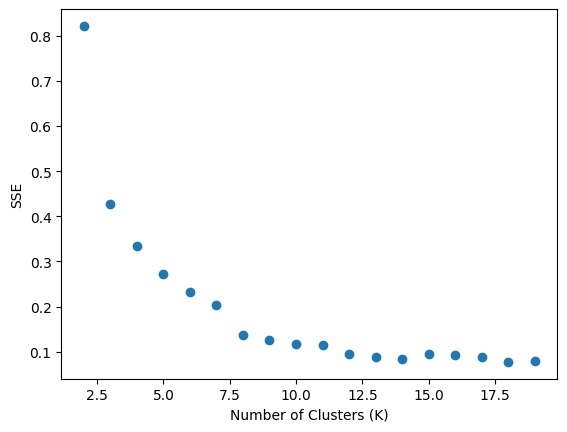

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cluster_number = range(2,20)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number,errors)
plt.show()

In [ ]:
kmeans = KMeans(featuresCol='features',k=3,distanceMeasure='cosine')
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   52|
|         2|   33|
|         0|   82|
+----------+-----+



In [ ]:
predictions=model.transform(final_data)

In [ ]:
pandas_df = predictions.toPandas()
pandas_df.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,features,prediction
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,"[90.2, 10.0, 7.58, 44.9, 1610.0, 9.44, 56.2, 5...",0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,"[16.6, 28.0, 6.55, 48.6, 9930.0, 4.49, 76.3, 1...",0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,"[27.3, 38.4, 4.17, 31.4, 12900.0, 16.1, 76.5, ...",0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,"[119.0, 62.3, 2.85, 42.9, 5900.0, 22.4, 60.1, ...",1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,"[10.3, 45.5, 6.03, 58.9, 19100.0, 1.44, 76.8, ...",1


In [ ]:
from pyspark.ml.feature import PCA
predictions.show()

+-------------------+----------+-------+------+-------+------+---------+----------+---------+-----+--------------------+----------+
|            country|child_mort|exports|health|imports|income|inflation|life_expec|total_fer| gdpp|            features|prediction|
+-------------------+----------+-------+------+-------+------+---------+----------+---------+-----+--------------------+----------+
|        Afghanistan|      90.2|   10.0|  7.58|   44.9|  1610|     9.44|      56.2|     5.82|  553|[90.2,10.0,7.58,4...|         0|
|            Albania|      16.6|   28.0|  6.55|   48.6|  9930|     4.49|      76.3|     1.65| 4090|[16.6,28.0,6.55,4...|         0|
|            Algeria|      27.3|   38.4|  4.17|   31.4| 12900|     16.1|      76.5|     2.89| 4460|[27.3,38.4,4.17,3...|         0|
|             Angola|     119.0|   62.3|  2.85|   42.9|  5900|     22.4|      60.1|     6.16| 3530|[119.0,62.3,2.85,...|         1|
|Antigua and Barbuda|      10.3|   45.5|  6.03|   58.9| 19100|     1.44|    

In [ ]:
pca = PCA(k=3,inputCol='features',outputCol='pcaFeatures')
pcaModel = pca.fit(predictions)

In [ ]:
results = pcaModel.transform(predictions).select('pcaFeatures')
results.show()

In [ ]:
pandasResults = results.toPandas()
pandasResults.head()

,pcaFeatures
0,"[1549.8693666935467, -703.9882142155617, 64.39..."
1,"[10026.058392626992, -3848.5819622899894, -2.2..."
2,"[12438.644795310163, -5619.797036318984, 14.05..."
3,"[6712.531447922697, -1487.3176650831945, 85.52..."
4,"[22261.139416490274, -4253.591086079125, -3.16..."


In [ ]:
PC1 = []
PC2 = []
PC3 = []
for vec in pandasResults.values:
    PC1.extend([vec[0][0]])
    PC2.extend([vec[0][1]])
    PC3.extend([vec[0][2]])

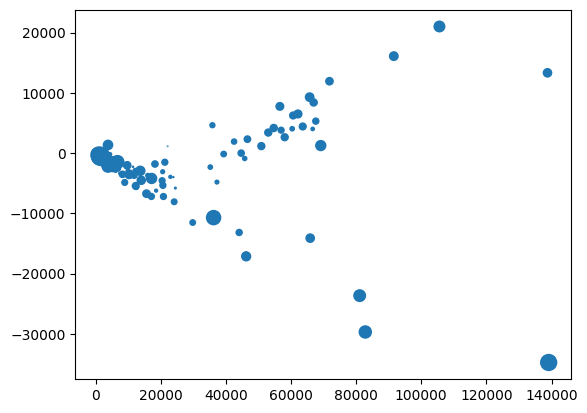

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(PC1, PC2, PC3)
plt.show()